# Bank Statement Classification

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import (make_scorer, accuracy_score, matthews_corrcoef, f1_score, precision_score, 
recall_score, confusion_matrix)
from skopt import BayesSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import warnings
pd.options.mode.chained_assignment = None

In [265]:
df = pd.read_csv('bankstatement.csv')

# Quick Analysis + Baseline

After importing the necessary libraries and the dataset, let's take a look at it.

In [266]:
df.head()

,is_correct_linking,payable_amount,payable_counter_party_name,payable_date_occurred,payable_direction,payable_document_type,payable_due_date,payable_due_date_with_early_payment_discount,payable_early_payment_discount_percent,payable_origin,payment_account_type,payment_amount,payable_reference,payment_counter_party_name,payment_date,payment_direction,payment_origin,payment_reference
0,0,416.21,"""Mystica"" e.V.",2018-02-28,incoming,Invoice,2018-03-30,NaN,0.0,supplier,bank_account,604.44,8121837424,Kolde Stadtpalais GmbH & Co. KG,2018-04-25,outgoing,supplier,Eref+92278-1 Vom 20180423 Mref+110140.13 Cred+...
1,0,49.83,Rußlandhilfe e.V.,2018-03-19,incoming,Invoice,2018-04-18,NaN,0.0,supplier,bank_account,19.87,5085056351,Fernseh-Hartmann GmbH,2018-02-23,outgoing,supplier,Eref+1507525303893117 Mref+7Xp2X3Y0Njvbgmdx)1L...
2,0,86.01,E.S.I. GmbH Energie-Service-Immobilien,2018-03-01,incoming,Invoice,NaN,NaN,NaN,supplier,bank_account,54.95,102753289,Vermögensverwaltung Grefer GmbH & Co. KG,2018-03-13,incoming,supplier,"D201945, RG B1716914/R066762 (104,80 EUR), Ers..."
3,0,16.99,Klar Plus GmbH,2018-06-09,incoming,ForeignInvoice,2018-07-09,NaN,NaN,supplier,credit_card,295.00,Klar Plus GmbH 09/06/2018,DOC-Gastro GmbH,2018-07-03,outgoing,supplier,0307 30.06 DOC-Gastro GmbH IE DUBLIN 6
4,1,12.28,WEKA-Solvent-Vertriebs GmbH,2018-07-17,incoming,Receipt,2018-07-17,NaN,NaN,supplier,cash_register,12.28,NaN,T-R RE-Fund I GmbH & Co. Retail 13 KG,2018-07-17,outgoing,supplier,"17.07.18, T-R RE-Fund I GmbH & Co. Retail 13 KG"


Looking at just the first 5 rows, I notice that for the first 4 rows, which are classified as 'not linked correctly' with the value 0, the values in the columns "payable amount" and "payment amount" are not the equal, while for the 5th row, which is classified as 1 or "correctly linked", the values are equal. Maybe this might help us creating a highly predictive feature with only a little effort

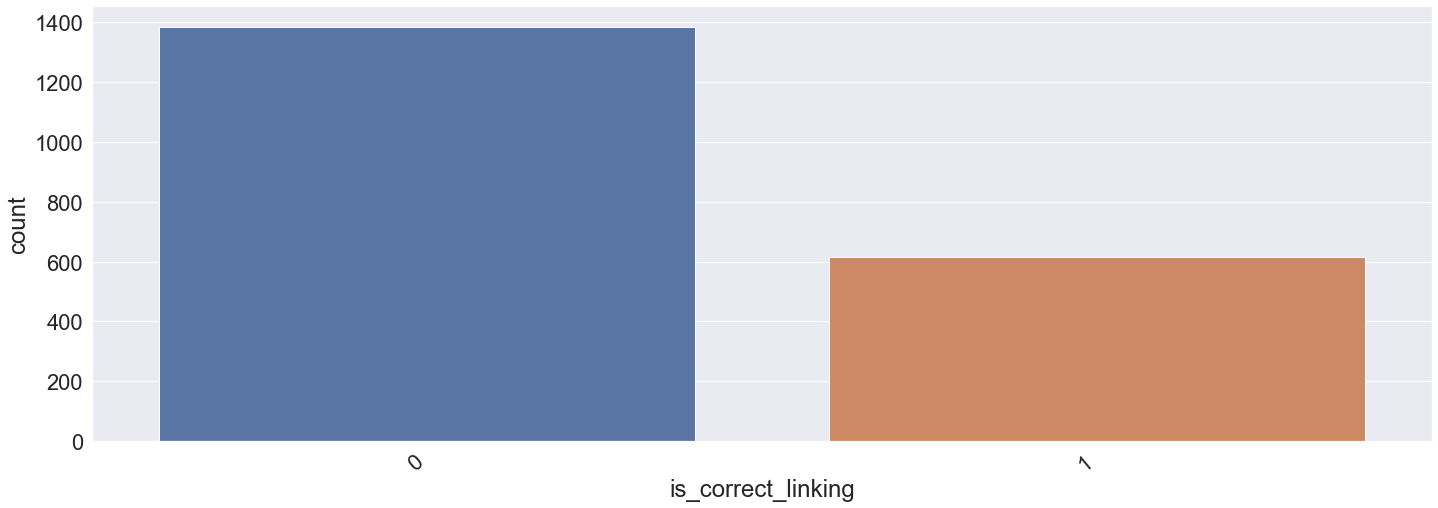

In [267]:
plt.figure(figsize=(24, 8))
sns.set(font_scale=2)
ax = sns.countplot(x="is_correct_linking", data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.show()

But let's take a look at the distribution of the target feature to create a baseline. As we can see around 2/3 of the data is labeled as "not correctly linked" or 1, so 1/3 is correctly labeled.

In [268]:
np.round(len(df[df['is_correct_linking']==0])/len(df),2)*100

69.0

This is verified and we can see that the majority class of 0 is 69% of all the data. This number will serve as the baseline accuracy for our model, as a lazy algorithm could just predict everything as 0 and would achieve a 69% accuracy with this approach. So for our model to add value, it will have to outperform this.

In [269]:
same = []
for row, row1 in zip(df['payable_amount'].iteritems(), df['payment_amount'].iteritems()):
    if row == row1:
        same.append(1)
    else:
        same.append(0)

In [270]:
df['payable_payment_same'] = same

But, let's get back to the initial intuition that the correctly linked data points have the same value in both "payable amount" and "payment amount" columns. So here we create an empty list and write a for-loop that adds the value 1 if for in each row respectively, the values both fields are equal and adds a 0 to the list, if they are different. we then simply append this list to our original dataframe as a new column.

In [271]:
df = df[['is_correct_linking', 'payable_amount', 'payment_amount', 'payable_payment_same']]

In [272]:
df.head(5)

,is_correct_linking,payable_amount,payment_amount,payable_payment_same
0,0,416.21,604.44,0
1,0,49.83,19.87,0
2,0,86.01,54.95,0
3,0,16.99,295.00,0
4,1,12.28,12.28,1


Our dataframe looks good and for now, let's just follow our intuition that the main driver for predictive power is this relationship between the 2 "payable amount" and "payment amount" columns, while disregarding and dropping the date and text columns. If this works well, it can save us a lot of time for preprocessing the date and text as well as being less computationally expensive.

In [273]:
df['pay_diff'] = df['payable_amount'] - df['payment_amount']
df['amount_ratio'] = np.round(df['payable_amount'] / df['payment_amount'], 2)

Let's go a bit further, though, and engineer some features. We add 2 new columns, the first holding the difference between the "payable amount" and "payment amount" and the 2nd dividing the values of those columns for every row.

In [274]:
df.head()

,is_correct_linking,payable_amount,payment_amount,payable_payment_same,pay_diff,amount_ratio
0,0,416.21,604.44,0,-188.23,0.69
1,0,49.83,19.87,0,29.96,2.51
2,0,86.01,54.95,0,31.06,1.57
3,0,16.99,295.00,0,-278.01,0.06
4,1,12.28,12.28,1,0.00,1.00


In [275]:
isof = IsolationForest(max_samples=500)
df['outlier'] = isof.fit_predict(df['pay_diff'].to_numpy().reshape(-1,1))
print('data point including outliers:', len(df))
df = df.loc[df['outlier'] == 1]
df.drop('outlier', axis=1, inplace=True)
print('data point excluding outliers:', len(df))

data point including outliers: 2000
data point excluding outliers: 1851


we then use the isolation forest methodology on the newly created "difference" column to remove outliers. This is an unsupervised approach, so fitting on the entire data is okay as no data leakage occurs. feel free to read further for how exactly isolation forests work: https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/tkdd11.pdf

We can see that 153 rows have been tagged and removed as outliers, which corresponds to around 7-8% of our data. Without prior domain knowledge, using this mathematical approach to identify outliers, is the next best solution in my opinion.

In [276]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('is_correct_linking', axis=1), df['is_correct_linking'], test_size=0.33, random_state=42, stratify=df['is_correct_linking'])
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

We then split the data into training and test data set and make sure we stratify it by our target feature so that both splits have the same 69/31 distribution of our target feature in order to retain the validity of our baseline.

In [277]:
params_xgb = {"n_estimators": [10,20,50,100],
              "max_depth": list(range(1, 11)),
              "learning_rate": [1e-3, 1e-2, 1e-1, 0.5, 1.],
              "subsample": list(np.arange(0.05, 1.01, 0.05)),
              "min_child_weight": list(range(1, 21)),
              "colsample_bytree": list(np.arange(0.1,1,0.1)),
              "reg_lambda": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.],
              "reg_alpha": [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1., 5., 10., 15., 20., 25.]

              }
xgb = XGBClassifier()
acs = make_scorer(accuracy_score, greater_is_better=True)
bcv = BayesSearchCV(xgb, params_xgb,cv=5, n_iter=50, random_state=42, verbose=0, n_jobs=1, n_points=50, scoring=acs)

we create instances of our xgboost implementation of a gradient boosting trees algorithm with a corresponding parameter space, our accuracy score as well as bayesian hyperparameter optimization and k-fold cross validation.

In [278]:
with warnings.catch_warnings():
    #The Bayes Optimizer Library throws some pretty lenghty FutureWarnings during fitting. We will ignore them.
    warnings.filterwarnings("ignore")
    bcv.fit(X_train, y_train)

In [279]:
print("Mean accuracy CV score xgb:", round(bcv.best_score_*100, 2))

Mean accuracy CV score xgb: 93.23


We run the cross validation and hyperparameter optimization and after it is finished, print the mean accuracy for all folds for the algorithm with the optimized parameters. The result is a very good one at 93.2% mean accuracy. Let's hope that we can achieve similar accuracy on our test data.

In [280]:
xgbc = bcv.best_estimator_
xgbc.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.30000000000000004, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.001, max_delta_step=0, max_depth=7,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0.0001,
              reg_lambda=0.001, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [281]:
y_pred = xgbc.predict(X_test)

next, we print the optimized parameters and fit the optimized algorithm on the entire training data and then let it predict on the unseen test data.

In [282]:
acc = accuracy_score(y_test, y_pred)
print('test data accuracy:', np.round(acc,4)*100,'%')

test data accuracy: 95.09 %


And the result is actually slightly better with 95.1% accuracy.

In [283]:
print('matthews correlation coefficient:',np.round(matthews_corrcoef(y_test, y_pred), 2))
print('precision:',np.round(precision_score(y_test, y_pred), 2))
print('recall:',np.round(recall_score(y_test, y_pred), 2))
print('f1 score:',np.round(f1_score(y_test, y_pred), 2))

matthews correlation coefficient: 0.89
precision: 0.96
recall: 0.88
f1 score: 0.92


In [284]:
pd.crosstab(y_pred, y_test, 
            rownames=['predicted'], 
            colnames=['actual'], margins=False, margins_name="Total")

actual,0,1
predicted,,
0,407,23
1,7,174


let us also try some other evaluation metrics such as precision, recall, f1-score as well as a confusion matrix. All of them validate the great accuracy score achieved previously.

# Conclusion

In the end, we can conclude that we have achieved a very satisfying result. What validates this result even more is the low amount of time, effort and complexity required to achieve it. All it took was some very high level analysis combined with simple feature engineering in order to achieve a result 26% above the baseline. 

This model can effortlessly be put into production and generate added value immediately, while one can work on tweaking it to achieve even better results in the second iteration. A great MVP!

This is a prime example of how being a good data scientist isn't always about using a newest, complex algorithm but more so about understanding the data in a simple intuitiv way and leveraging that into a productive model.